# **In-Class Lab: A/B Testing on a Marketing Campaign**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

## **Part 1: Data Exploration and Preparation**

## Step 1: Load the Data

In [7]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [9]:
df.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

## Step 2: Data Cleaning

In [11]:
# Identify if there are any duplicate users (users who appear in both the Control and Test groups)
treatment = df[df["group"] == "treatment"]
control = df[df["group"] == "control"]
duplicate = pd.merge(treatment, control, how="inner", on="user_id").sort_values(by=["user_id"])

# Extract the data except duplicate
df = df[~df["user_id"].isin(duplicate["user_id"])]
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


## Step 3: Descriptive Statistics

In [14]:
# Calculate basic summary statistics (e.g., mean, median) for conversion rates, page views, and session time.
df.describe()

,user_id,converted
count,290688.000000,290688.000000
mean,787982.492504,0.119637
std,91219.032967,0.324537
min,630000.000000,0.000000
25%,709028.750000,0.000000
50%,787940.500000,0.000000
75%,866930.250000,0.000000
max,945999.000000,1.000000


In [18]:
# Group the data by landing page and display the average conversion rate for each group.
df[["landing_page", "converted"]].groupby("landing_page")["converted"].mean()

landing_page
new_page    0.118881
old_page    0.120393
Name: converted, dtype: float64

## **Part 2: Hypothesis Formulation**

## Step 1: Define Hypotheses

### Null Hypothesis(H0) : The new landing page has no effect on conversion rates.
### Alternative Hypothesis(H1) : The new landing page increases conversion rates. 

## Step 2: Data Visualization

In [26]:
# Create a bar plot that visualizes the conversion rates for the Test and Control groups.
x = df.groupby(["converted", "group"])["converted"].value_counts().unstack()
x

group,control,treatment
converted,,
0,127820,128091
1,17487,17290


In [28]:
conv_rate_control = (x["control"][1] / x["control"].sum())
conv_rate_treatment = (x["treatment"][1] / x["treatment"].sum())
data = {"group": ["control", "treatment"],
       "conversion_rate": [conv_rate_control, conv_rate_treatment]}
x1 = pd.DataFrame(data)
x1

,group,conversion_rate
0,control,0.120345
1,treatment,0.118929


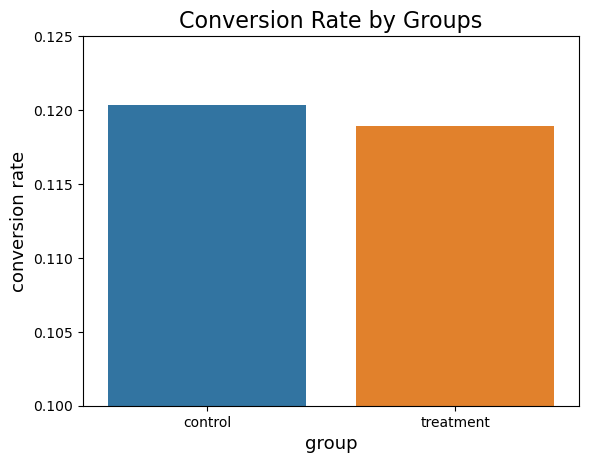

In [30]:
sns.barplot(data=x1, x="group", y="conversion_rate")
plt.xticks(rotation=360)
plt.title("Conversion Rate by Groups", fontsize=16)
plt.xlabel("group", fontsize=13)
plt.ylabel("conversion rate", fontsize=13)
plt.ylim(0.10, 0.125)
plt.show()

The conversion rate in control group was slitely higher than the test group.

## **Part 3: A/B Testing (Two-Proportion Z-Test)**

## Step 1: Perform a Two-Proportion Z-Test

In [67]:
# Perform a two-proportion z-test to determine whether the difference in conversion rates between the Control and Test groups is statistically significant.
# Parameters
n1_2 = x["control"].sum() # sample size group 1
x1_2 = x["control"][1] # successes control
n2_2 = x["treatment"].sum() # sample size group 2
x2_2 = x["treatment"][1] # successes treatment
# Sample proportion (conversion rates for both the Control and Test groups)
p1_2 = x1_2 / n1_2
p2_2 = x2_2 / n2_2

# # Pooled proportion
p_pooled = (x1_2 + x2_2) / (n1_2 + n2_2)

z = (p1_2 - p2_2) / math.sqrt(p_pooled * (1 - p_pooled) * (1 / n1_2 + 1 / n2_2))
p_value = 2 * (1 - stats.norm.cdf(z))
print(f"z_score: {z}")
print(f"p_value: {p_value}")

z_score: 1.176469036591924
p_value: 0.23940749849829834


## Step 2: Interpretation

Since the p-value (0.23) is greater than 0.05, we fail to reject the null hypothesis. There is no significant evidence to suggest that the new landing page increases conversion rates. 

The company should not switch to the new landing page because there is no significant evidence to suggest that the new landing page increases conversion rates based on a Z-Test.

## **Part 4: Confidence Intervals and Visualization**

## Step 1: Confidence Intervals

In [42]:
# confidence intervals for the treatment group
confidence_int_treatment = stats.t.interval(confidence=0.95, df=len(treatment)-1,
               loc=np.mean(treatment["converted"]),
               scale=stats.sem(treatment["converted"]))
confidence_int_treatment

(0.11726639400849966, 0.12057276512129746)

In [44]:
# confidence intervals for the control group
confidence_int_control = stats.t.interval(confidence=0.95, df=len(control)-1,
               loc=np.mean(control["converted"]),
               scale=stats.sem(control["converted"]))
confidence_int_control

(0.11873672068528375, 0.12206163803266847)

* Confidence intervals indicate that there is a 95% certainty that this range will contain the population mean.
* The larger the sample size, the narrower the confidence interval becomes.
* The result from Step 1 shows a narrow confidence interval, which indicates more precision and reliability.

## Step 2: Visualization of Confidence Intervals

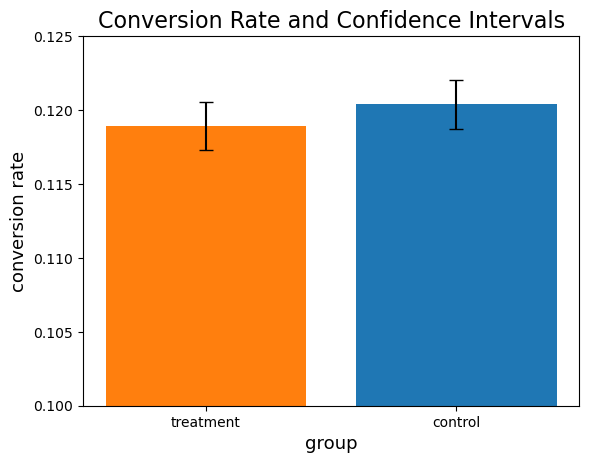

In [48]:
# Create a plot that shows the conversion rates for both groups, including the confidence intervals as error bars.
treatment_mean = treatment["converted"].mean()
control_mean = control["converted"].mean()
treatment_error = (confidence_int_treatment[1] - confidence_int_treatment[0]) / 2
control_error = (confidence_int_control[1] - confidence_int_control[0]) / 2

plt.bar(["treatment", "control"], [treatment_mean, control_mean], yerr=[treatment_error, control_error], capsize=5, color = ["#ff7f0e", "#1f77b4"])
plt.title("Conversion Rate and Confidence Intervals", fontsize=16)
plt.xlabel("group", fontsize=13)
plt.ylabel("conversion rate", fontsize=13)
plt.ylim(0.10, 0.125)
plt.show()

## **Part 5: Subgroup Analysis**

## Step 1: Time-Based Analysis

In [52]:
# Extract the hour of the day that each user visited the website
sr = pd.to_datetime(df["timestamp"])
df["hour"] = sr.dt.hour
df.head()

,user_id,timestamp,group,landing_page,converted,hour
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,22
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,8
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,16
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,18
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1


In [54]:
hour_converted = df.groupby(["hour", "landing_page"])["converted"].value_counts().unstack()
conversion_rate_hour = hour_converted[1] / hour_converted.sum(axis=1)

In [56]:
conversion_rate_hour = hour_converted[1] / hour_converted.sum(axis=1)
df_conversion_rate_hour = conversion_rate_hour.reset_index()
df_conversion_rate_hour.columns = ["hour", "landing_page", "conversion_rate"]

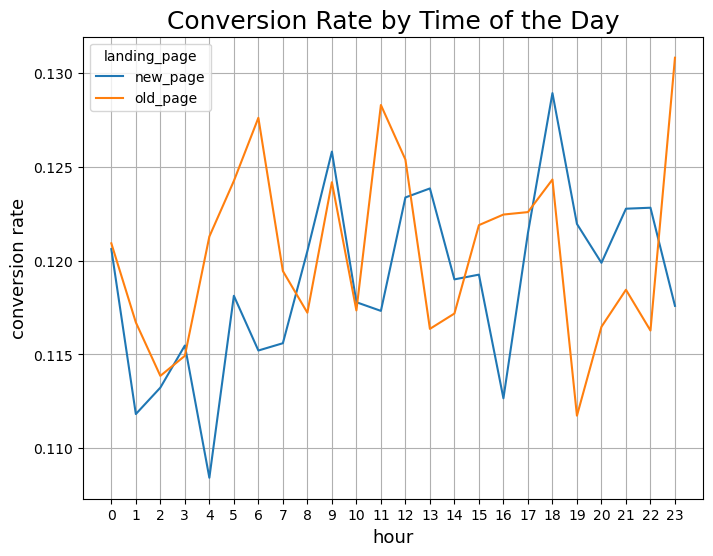

In [58]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df_conversion_rate_hour, x="hour", y="conversion_rate", hue="landing_page")
plt.xticks(np.arange(0,24,1))
plt.title("Conversion Rate by Time of the Day", fontsize=18)
plt.xlabel("hour", fontsize=13)
plt.ylabel("conversion rate", fontsize=13)
plt.grid()
plt.show()

## Step 2: Interpretation

* The conversion rate fluctuates for both the new and old pages.
* There is a relatively big gap between the landing pages when the old page performs better than the new page at the same time of day.
* The conversion rate for the new landing page is relatively low in the early morning (4 AM is the lowest), indicating lower effectiveness. As time progresses, the conversion rate increases (5–6 PM is the highest), indicating greater effectiveness.

## **Part 6: Conclusion**

## Step 1: Summarize Findings

* As a result of A/B test, the new landing page did not show a statistically significant improvement in conversion rate. 
* People more rely on the page that was already exsisting or used for a long period of time. 
* I observed from the subgroup analysis that the conversion rate completely varies depending on what time people access the page.

## Step 2: Recommendations

* Given the result of Z-test, and the lower conversion rate, the company should not adopt the new landing page. 
* If the data had more information, I could get more meaningful results. 
* The ideal duration for running an A/B test is 2 weeks, but it should not exceed 6 to 8 weeks. Depending on when the test is conducted, there is a possibility that the data may obscure regular behavior.